<font color='red' size=5>**Kaggle Tab 201204 final script**</font>

This is the script used for producing final solution for 
<a href="https://www.kaggle.com/competitions/tabular-playground-series-apr-2022">**KaggleTab_2022 April competition**.</a><br>
The subject of the competition was binary classification on multivariative time series of short length (10 features X 60 datapoints in a single timeseries)

The solution is based on slighlty modified features set and network based on combinaed LSTM and GRU layers.<br>
It scored AUC=0.98240 (52 position/848 teams), comparing to first place AUC=0.99249. 



In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import uuid
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import mlflow
import nni
import sklearn
import scipy
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization,  Dropout, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate, Bidirectional, GRU, Multiply
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GroupShuffleSplit
from tabulate import tabulate
import numpy as np

for m in [sklearn, pd, np, scipy,tf, mlflow]:
    print(f"{m.__name__:15s}:{m.__version__}")

sklearn        :1.0.1
pandas         :1.3.5
numpy          :1.19.5
scipy          :1.7.3
tensorflow     :2.4.0
mlflow         :1.24.0


# Params

Params were optimized using <a href=https://github.com/microsoft/nni>NeuralNetwork Intelligence</a>.

In [2]:
params = {
    'ts_data_dimensions': (60,  273),
    'n_splits': 17,
}

params['transforming_quantiles'] = 3000
params['transforming_distrib'] = 'normal'
params['initial_lr'] = 3e-4
params['adam_beta1']=0.903
params['adam_amsgrad']=True 
params['batch_size'] = 80
params['lstm_dropout'] = 0.1075720328040613
params['gru_dropout'] = 0.008991644719714522
params["dense_0_drop_ratio"] = 0.367
params["dense_1_drop_ratio"] = 0.092
params["dense_0_units"] = 1792
params["dense_1_units"] = 256

# Data loading
- dataset used here was an oryginall features with some time series related features added (lead, lag, rolling mean etc.)
- neither scalar characterristics of time series data nor FFT transformation were not used

In [3]:
TRPATH = "/mnt/workdata/_WORK_/Kaggle_202204/data_1/"

train_ts_datafile = os.path.join(TRPATH, "train_transformed_1.pkl")
test_ts_datafile = os.path.join(TRPATH, "test_transformed_1.pkl")
train_labels = os.path.join(TRPATH, "train_labels.zip")

train_ts_df = pd.read_pickle(train_ts_datafile)
train_labels = pd.read_pickle(train_labels)
test_ts_df = pd.read_pickle(test_ts_datafile)

sensor_names = train_ts_df.columns[3:]

# the data mus be reshapoed to provide 60x13 matrices as input
SEQ_LEN = 60 # each sequence is 60 samples long
train_seq_num = int(train_ts_df.shape[0]/SEQ_LEN) # num of train sequences (with repeated subjects)
test_seq_num = int(test_ts_df.shape[0]/SEQ_LEN) # num of test sequences (with repeated subjects)

ts = QuantileTransformer(n_quantiles=params['transforming_quantiles'],
                         output_distribution=params['transforming_distrib'],
                         random_state=123)

train_ts_data_=pd.DataFrame(ts.fit_transform(train_ts_df[sensor_names]), columns=sensor_names)
test_ts_data_ = pd.DataFrame(ts.transform(test_ts_df[sensor_names]), columns=sensor_names)

sensor_num = len(sensor_names)

train_ts_data = train_ts_data_.values.reshape(train_seq_num, SEQ_LEN, sensor_num)
test_ts_data = test_ts_data_.values.reshape(test_seq_num, SEQ_LEN, sensor_num)
groups=train_ts_df.loc[train_ts_df['step']==0,'subject']

# Model definition

In [4]:
def define_model(params: dict):
    input_layer_1 = Input(shape=params['ts_data_dimensions'], name='input_1')

    batch_norm_1 = BatchNormalization(epsilon=1e-6)(input_layer_1)

    lstm0 = Bidirectional(LSTM(units=768, return_sequences=True, dropout= params['lstm_dropout']))(batch_norm_1)
    lstm1 = Bidirectional(LSTM(units=512, return_sequences=True, dropout=params['lstm_dropout']))(lstm0)
    lstm2 = Bidirectional(LSTM(units=384, return_sequences=True, dropout=params['lstm_dropout']))(lstm1)
    lstm3 = Bidirectional(LSTM(units=256, return_sequences=True, dropout=params['lstm_dropout']))(lstm2)
    lstm4 = Bidirectional(LSTM(units=128, return_sequences=True, dropout=params['lstm_dropout']))(lstm3)

    gru1 = Bidirectional(GRU(units=384, return_sequences=True, dropout= params['gru_dropout']))(lstm1)
    matmul1 = Multiply()([lstm2, gru1])

    gru2 = Bidirectional(GRU(units=256, return_sequences=True, dropout= params['gru_dropout']))(matmul1)
    matmul2 = Multiply()([lstm3, gru2])

    gru3 = Bidirectional(GRU(units=128, return_sequences=True, dropout= params['gru_dropout']))(matmul2)

    concat = Concatenate(axis=2)([lstm0, lstm2, lstm4, lstm3, gru1, gru2, gru3])
    gmp = GlobalMaxPooling1D()(concat)
    drop = Dropout(rate=params['dense_0_drop_ratio'])(gmp)
    dense = Dense(params["dense_0_units"],activation='relu')(drop)
    drop = Dropout(rate=params['dense_1_drop_ratio'])(dense)
    dense = Dense(params["dense_0_units"], activation='relu')(drop)
    output_layer = Dense(1, activation="sigmoid", name='output_layer')(dense)
    model = Model(inputs=input_layer_1,
                  outputs=output_layer)
    return model

# Model training

2022-04-30 13:18:43.912345: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-30 13:18:43.912912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-30 13:18:43.941702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 13:18:43.942433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:49:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-30 13:18:43.942455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-30 13:18:43.944129: I tensorflow/stream_executor/platform/defaul

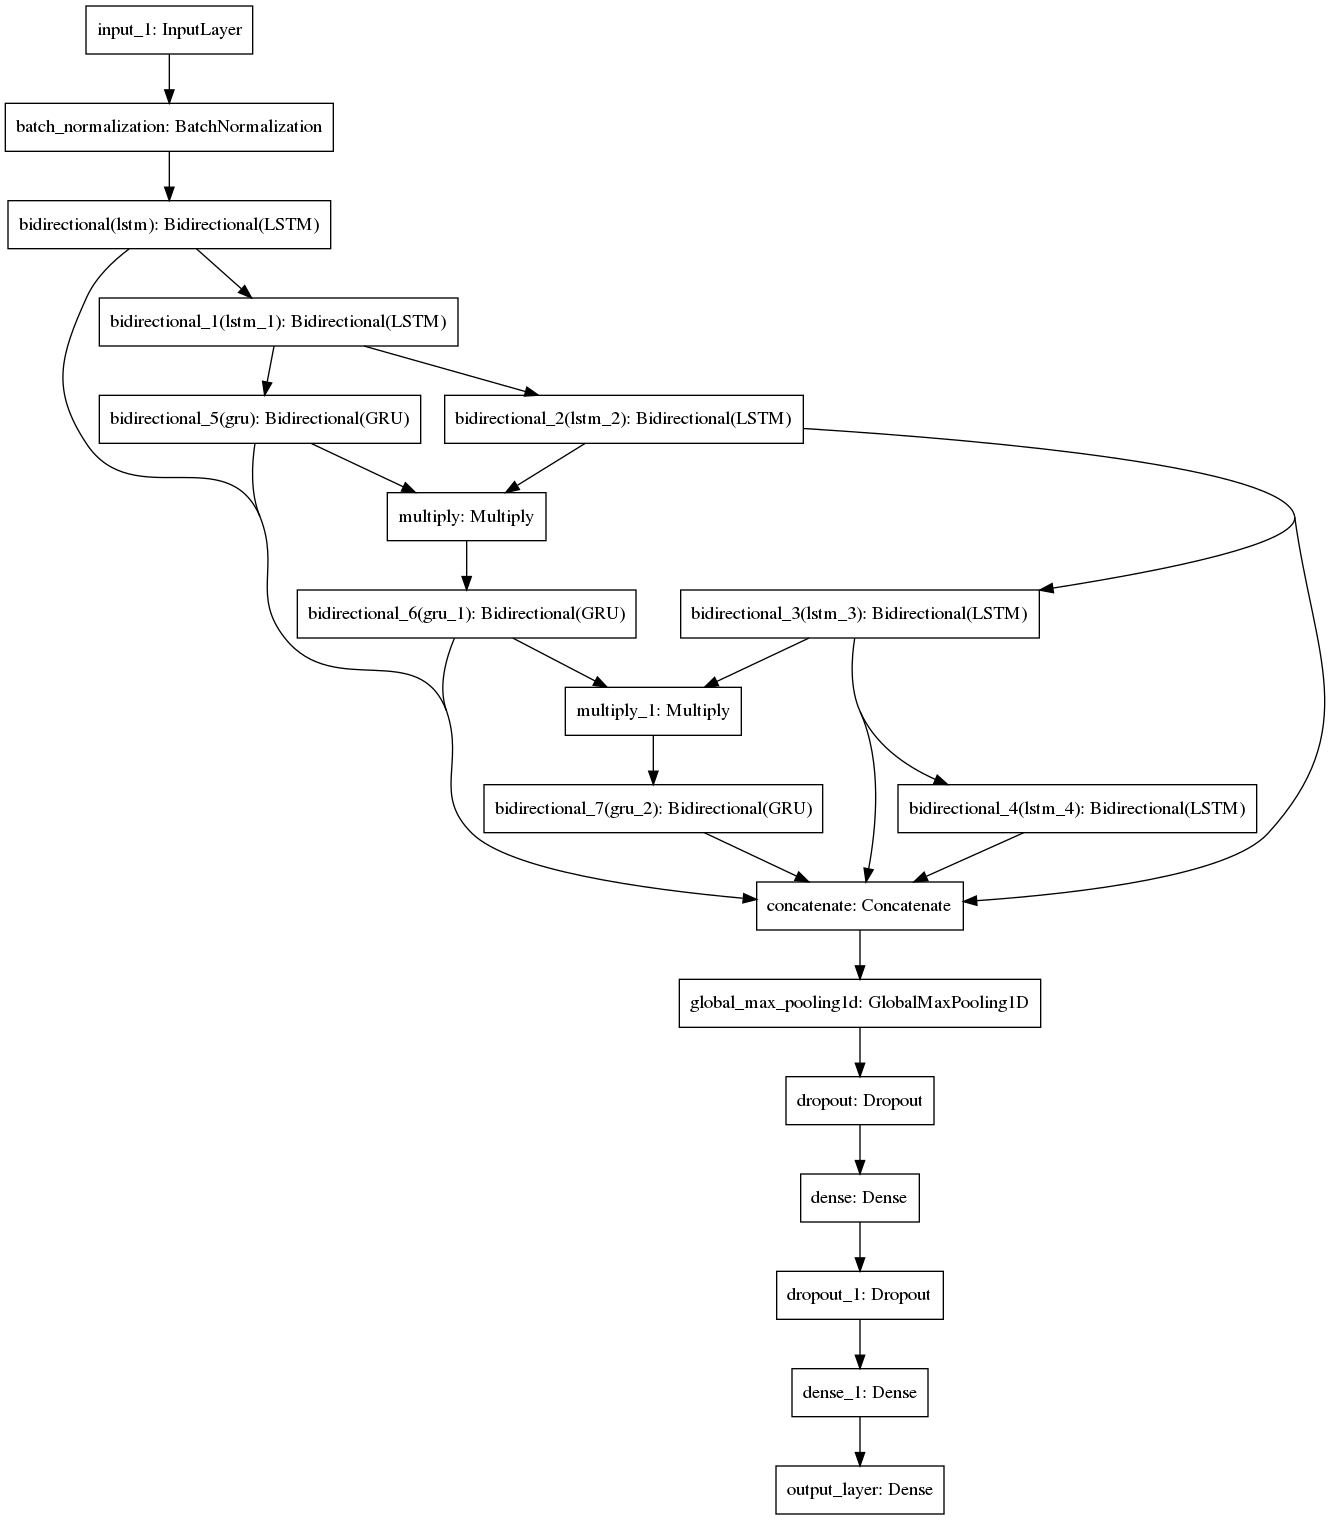

In [5]:
MAX_EPOCH = 100
model = define_model(params)
tf.keras.utils.plot_model(model)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 273)]    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 273)      1092        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 1536)     6402048     batch_normalization[0][0]        
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 1024)     8392704     bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
# group shuffle split was used here to avoid the influence of records from the same subject
# test subject and train subject do not have any overlap, they are separated.
splitter = GroupShuffleSplit(n_splits=params['n_splits'], random_state=123)
splits=splitter.split(X=train_ts_data, y=train_labels[["state"]].values, groups=groups)
idx = 0
global_results = dict()
test_predictions=dict()
val_predictions=dict()

Split number: 0, Train: (20609, 60, 273), validation: (5359, 60, 273)


2022-04-30 13:18:50.620685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-30 13:18:50.640111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700015000 Hz
2022-04-30 13:19:00.698246: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-30 13:19:00.964135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-30 13:19:00.988456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8



Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


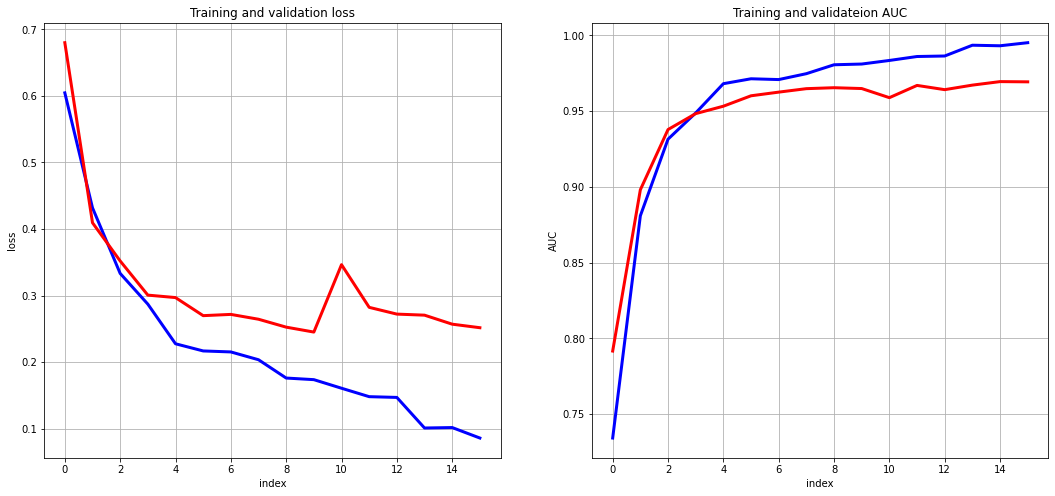

Split number: 1, Train: (20707, 60, 273), validation: (5261, 60, 273)

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


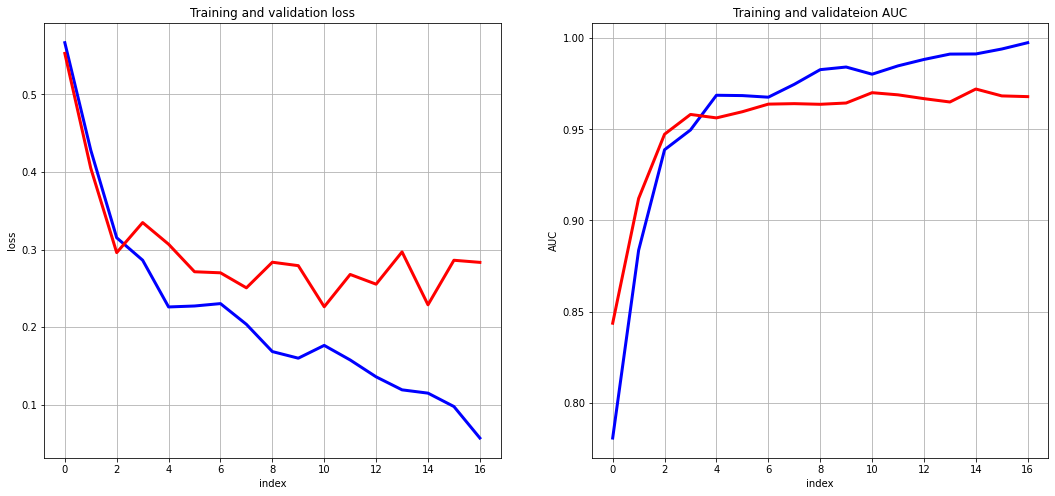

Split number: 2, Train: (20982, 60, 273), validation: (4986, 60, 273)

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


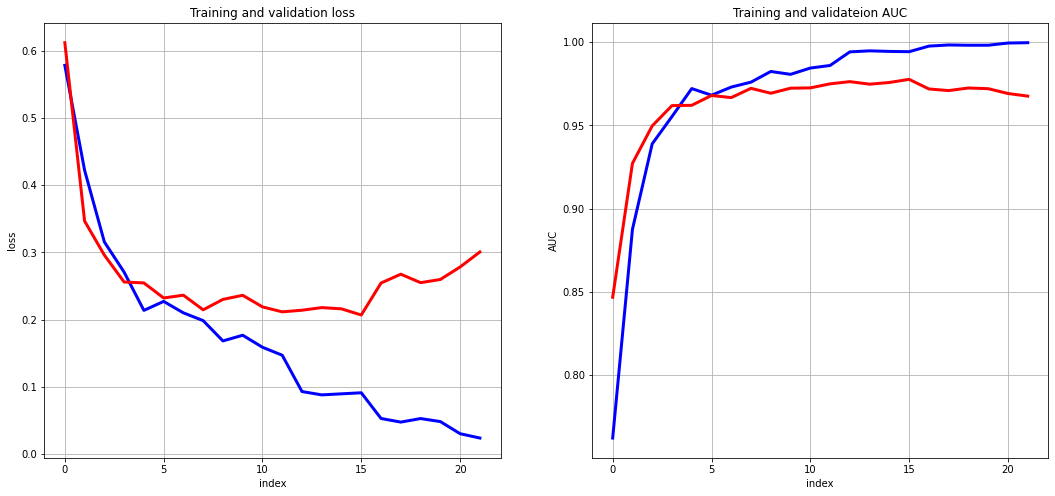

Split number: 3, Train: (20386, 60, 273), validation: (5582, 60, 273)

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


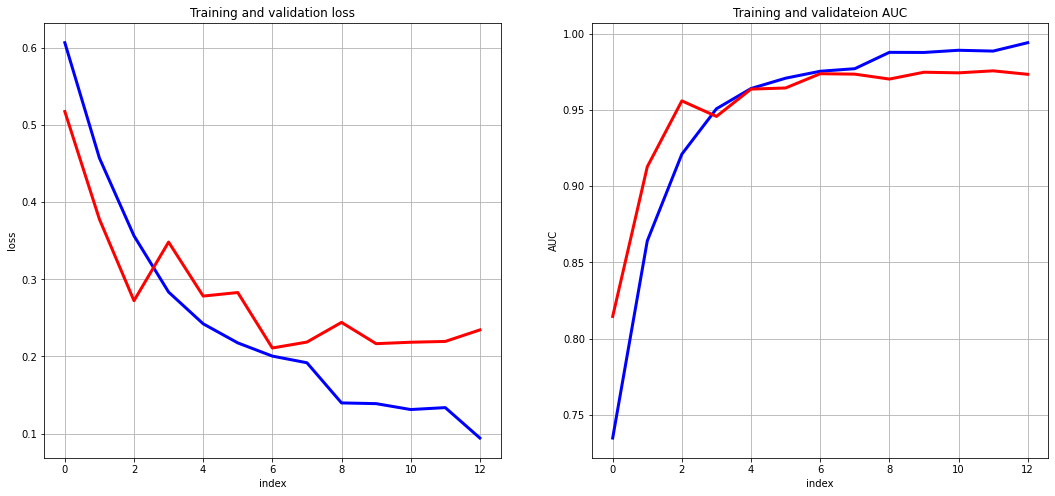

Split number: 4, Train: (20930, 60, 273), validation: (5038, 60, 273)

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


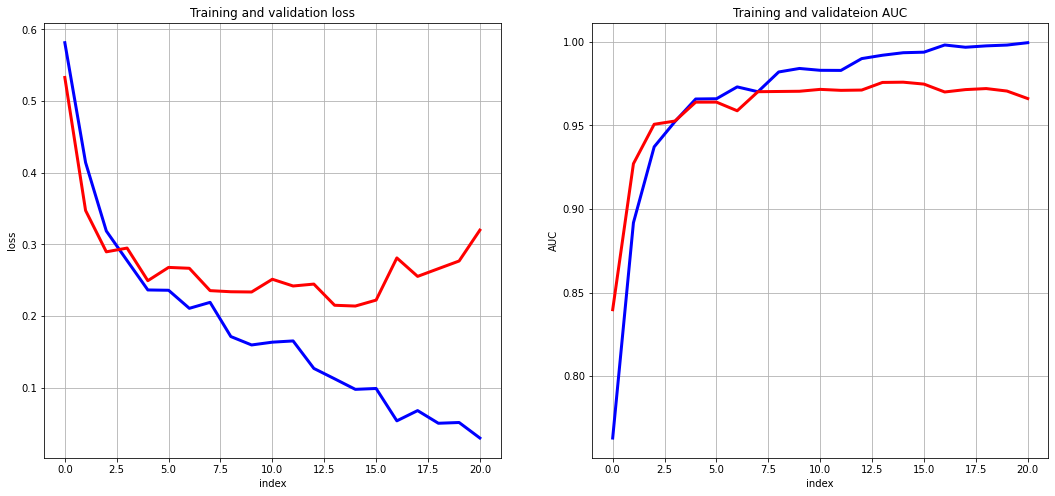

Split number: 5, Train: (21189, 60, 273), validation: (4779, 60, 273)

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


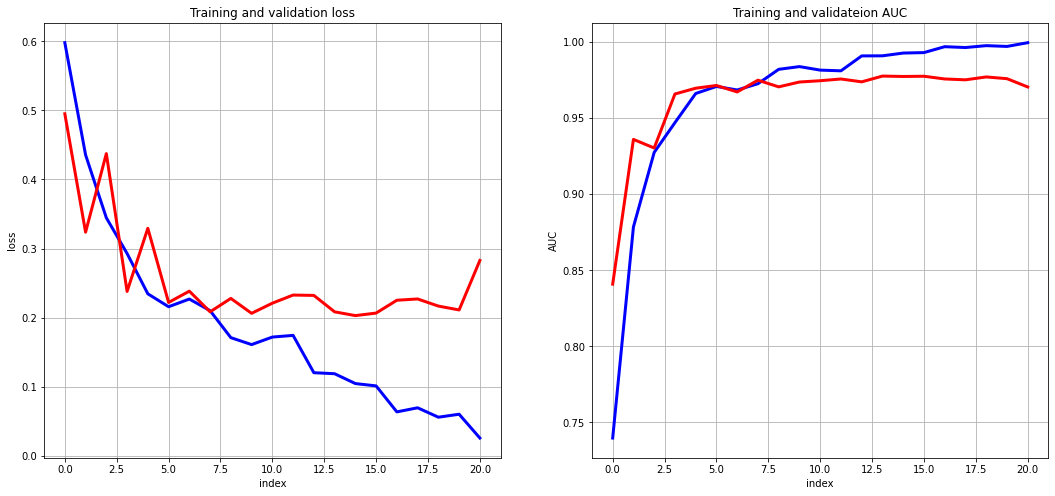

Split number: 6, Train: (20748, 60, 273), validation: (5220, 60, 273)

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


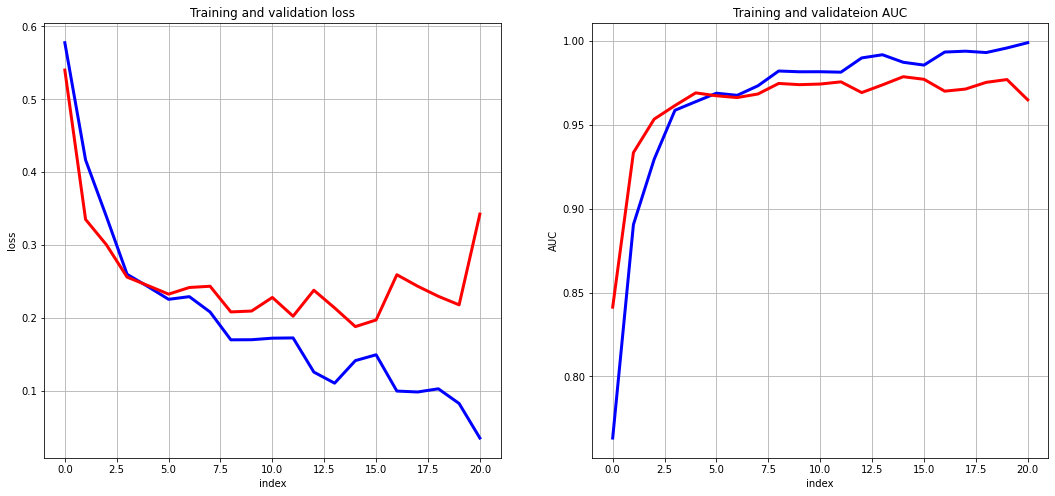

Split number: 7, Train: (20622, 60, 273), validation: (5346, 60, 273)

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


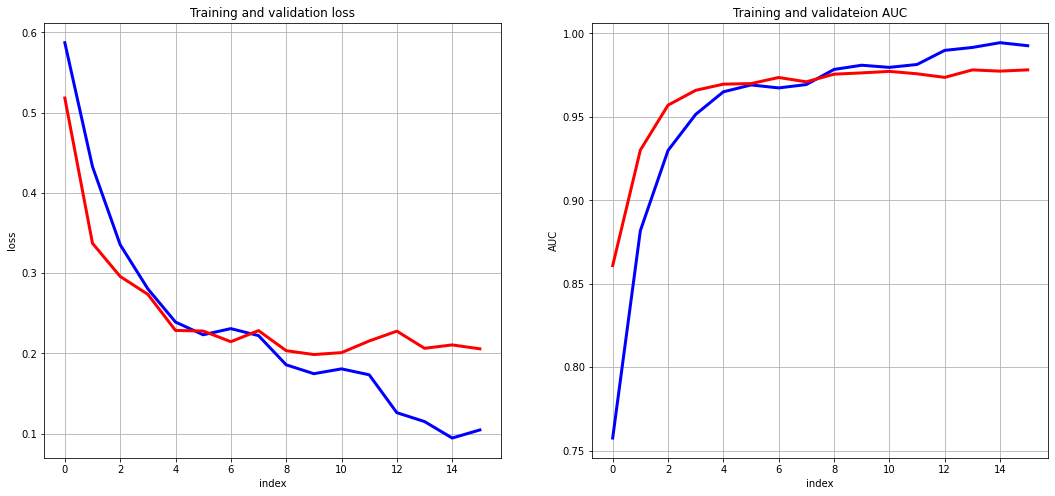

Split number: 8, Train: (21154, 60, 273), validation: (4814, 60, 273)

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


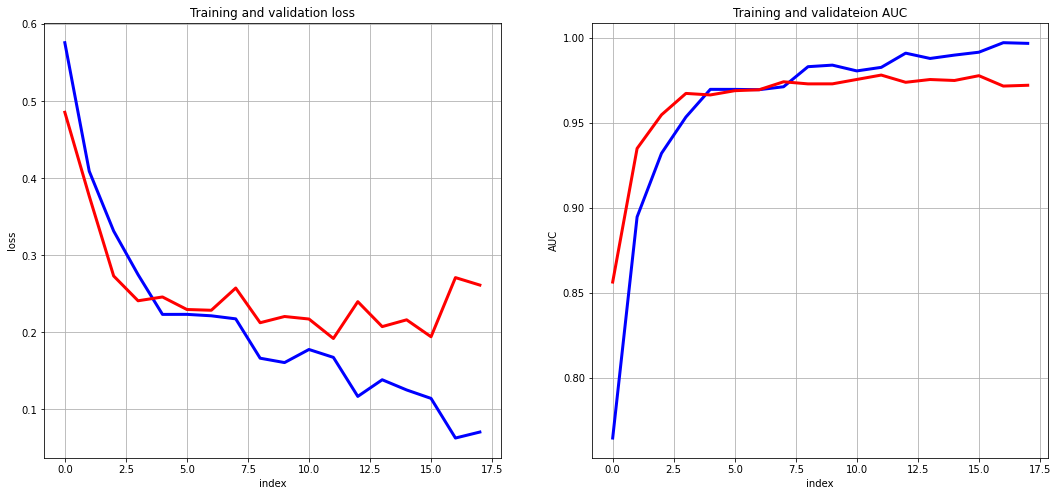

Split number: 9, Train: (20903, 60, 273), validation: (5065, 60, 273)

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


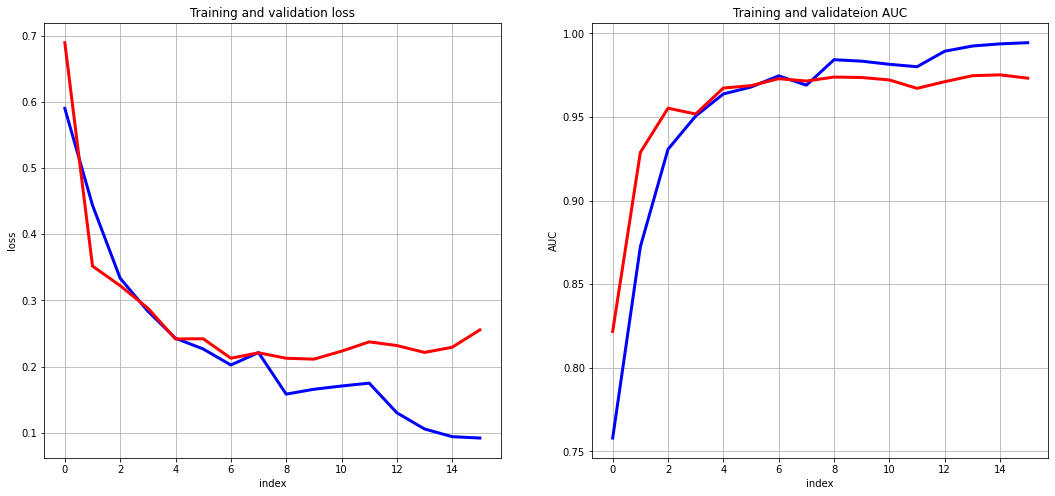

Split number: 10, Train: (20677, 60, 273), validation: (5291, 60, 273)

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


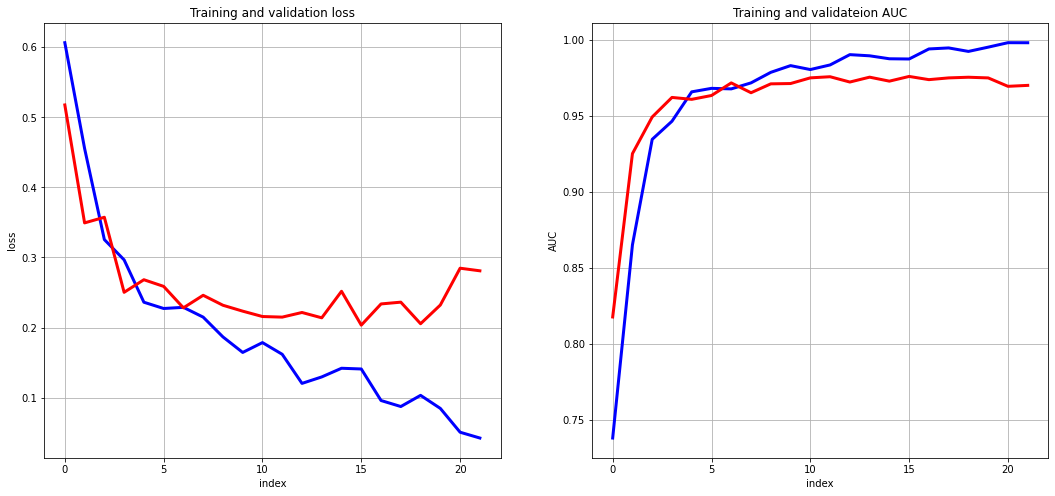

Split number: 11, Train: (20565, 60, 273), validation: (5403, 60, 273)

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


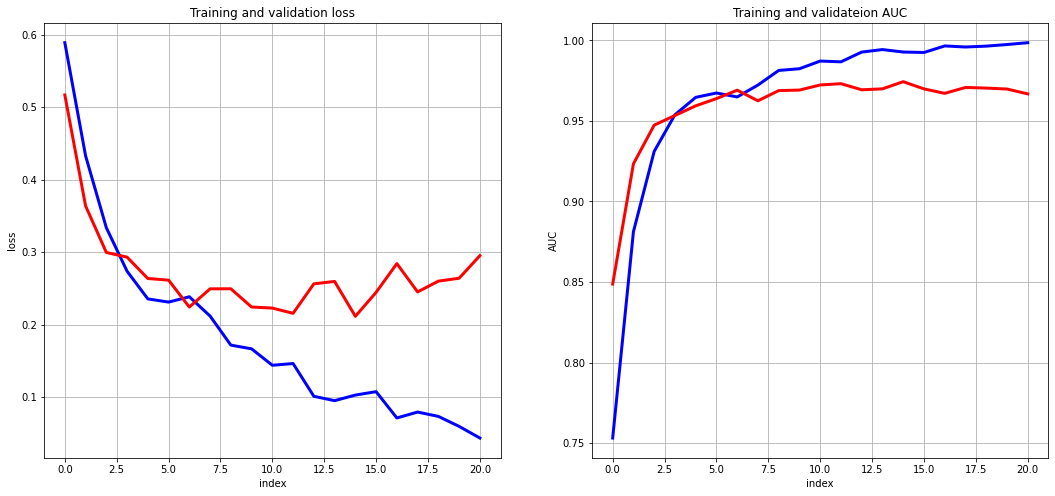

Split number: 12, Train: (20694, 60, 273), validation: (5274, 60, 273)

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


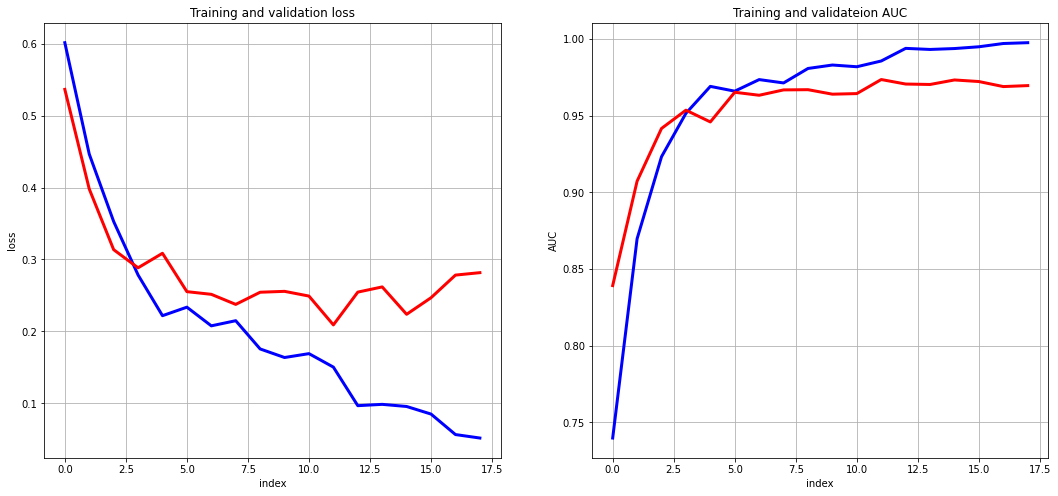

Split number: 13, Train: (20579, 60, 273), validation: (5389, 60, 273)

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


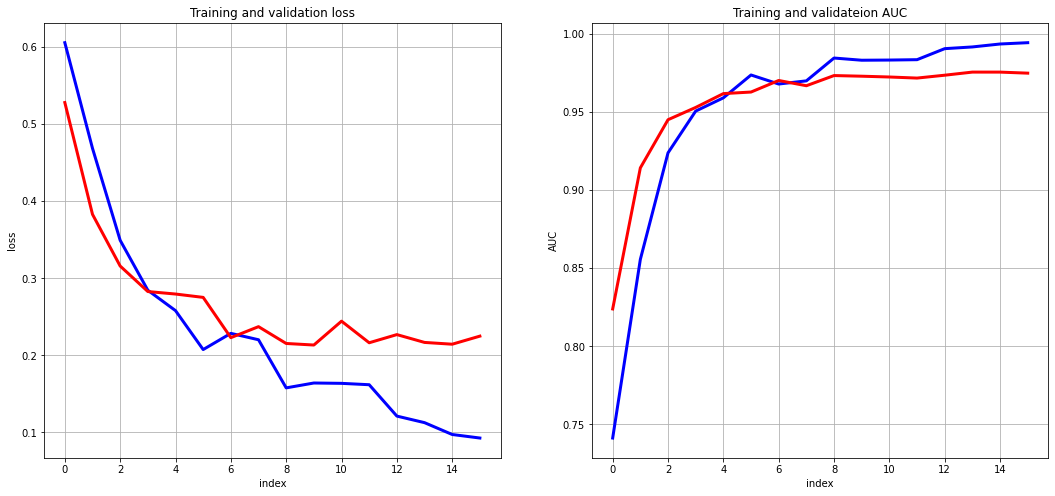

Split number: 14, Train: (20807, 60, 273), validation: (5161, 60, 273)

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


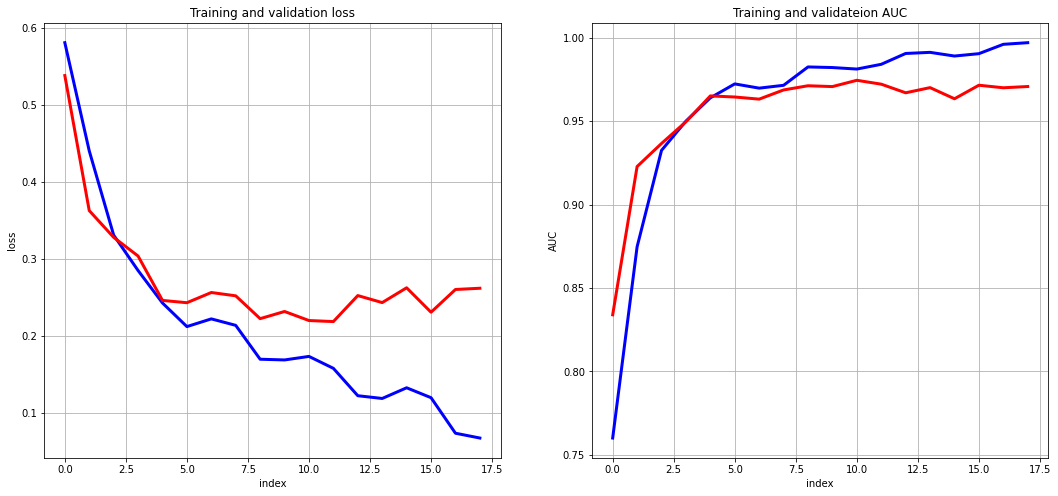

Split number: 15, Train: (20613, 60, 273), validation: (5355, 60, 273)

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


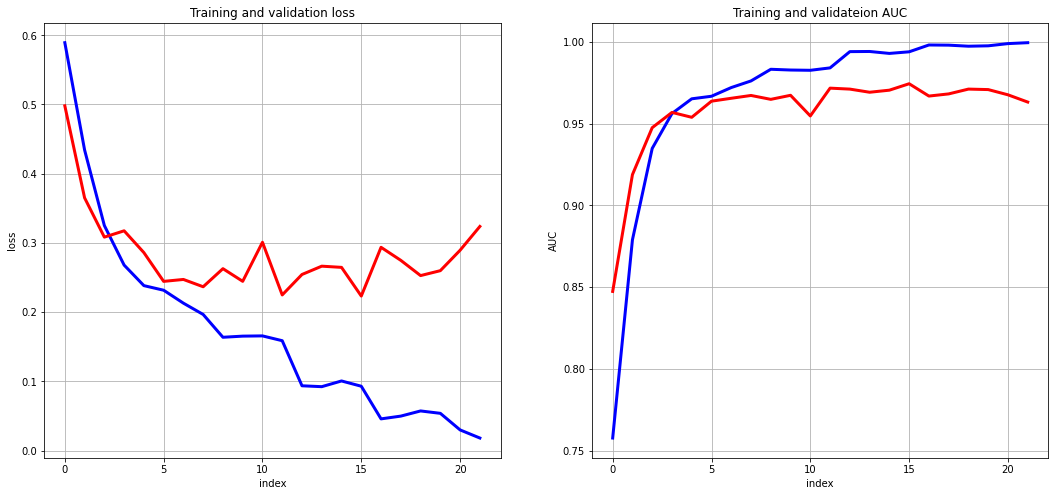

Split number: 16, Train: (20849, 60, 273), validation: (5119, 60, 273)

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


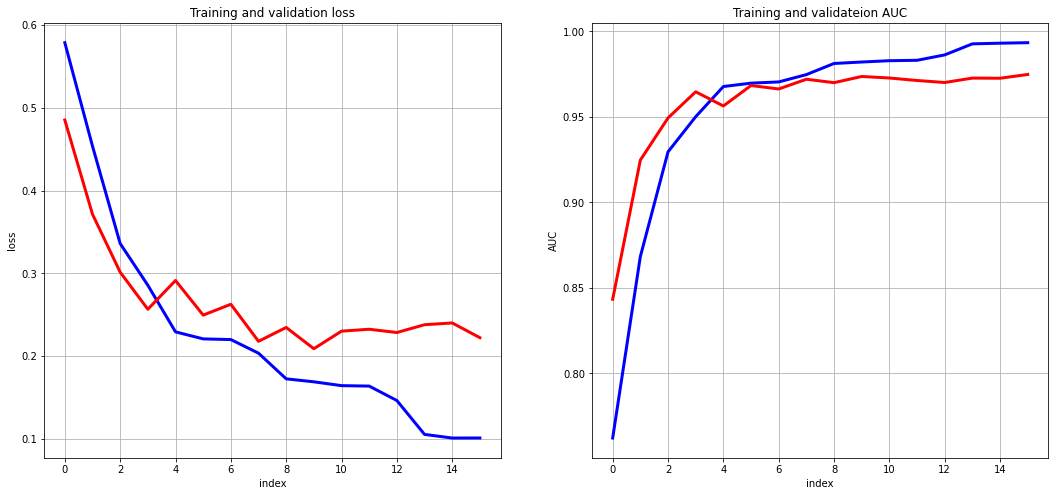

In [8]:
for split in splits:
    train_ts_X = train_ts_data[split[0]]
    train_y = train_labels[["state"]].values[split[0]]
    val_ts_X = train_ts_data[split[1]]
    val_y = train_labels[["state"]].values[split[1]]

    print(f"Split number: {idx}, Train: {train_ts_X.shape}, validation: {val_ts_X.shape}")
    model = define_model(params)
    model.compile(
        optimizer=Adam(
            learning_rate=params['initial_lr'],
            beta_1 = params['adam_beta1'],
            amsgrad = params['adam_amsgrad']),
        loss='binary_crossentropy',
        metrics=[
            AUC(name='AUC'),
        ])
    
    history = model.fit(
        x=train_ts_X,
        y=train_y,
        callbacks=[
            ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1),
            EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True),
        ],
        batch_size=params['batch_size'],
        epochs=MAX_EPOCH, 
        steps_per_epoch = (train_ts_X.shape[0] // params['batch_size']) // 4,
        validation_data=(val_ts_X, val_y), 
        verbose=0
    )

    # plot training result
    _=pd.DataFrame.from_dict(history.history).reset_index()
    fig, ax=plt.subplots(1,2, figsize=(18,8))
    sns.lineplot(x='index', y='loss', data=_, ax=ax[0], linewidth=3, color='blue')
    sns.lineplot(x='index', y='val_loss', data=_, ax=ax[0], linewidth=3, color='red')
    ax[0].grid('both')
    ax[0].set_title('Training and validation loss')
    sns.lineplot(x='index', y='AUC', data=_, ax=ax[1], linewidth=3, color='blue')
    sns.lineplot(x='index', y='val_AUC', data=_, ax=ax[1], linewidth=3, color='red')
    ax[1].grid('both')
    ax[1].set_title('Training and validateion AUC');
    plt.show()    

    val_pred = model.predict(x=val_ts_X)
    val_predictions[idx]={'split':split, 'val_y':val_y, 'val_pred':val_pred}
    
    test_pred = model.predict(x=test_ts_data)
    test_predictions[idx] = test_pred
    result_df = pd.DataFrame.from_dict(history.history)
    results = result_df.loc[result_df['val_loss'] == result_df['val_loss'].min()]
    results = results.to_dict(orient='list')
    global_results[idx]={
        'fin_val_loss': results['val_loss'][0],
        'fin_loss': results['loss'][0],
        'fin_val_AUC': results['val_AUC'][0],
        'fin_AUC': results['AUC'][0]
    }
    tf.keras.backend.clear_session()
    idx += 1

In [9]:
fold_scores=pd.DataFrame.from_dict(global_results).T
print(tabulate(fold_scores, headers='keys', floatfmt=".4f", tablefmt='fancy_grid'))
fold_scores.mean().head()


╒════╤════════════════╤════════════╤═══════════════╤═══════════╕
│    │   fin_val_loss │   fin_loss │   fin_val_AUC │   fin_AUC │
╞════╪════════════════╪════════════╪═══════════════╪═══════════╡
│  0 │         0.2452 │     0.1738 │        0.9649 │    0.9810 │
├────┼────────────────┼────────────┼───────────────┼───────────┤
│  1 │         0.2263 │     0.1765 │        0.9700 │    0.9802 │
├────┼────────────────┼────────────┼───────────────┼───────────┤
│  2 │         0.2068 │     0.0911 │        0.9776 │    0.9942 │
├────┼────────────────┼────────────┼───────────────┼───────────┤
│  3 │         0.2109 │     0.2005 │        0.9738 │    0.9754 │
├────┼────────────────┼────────────┼───────────────┼───────────┤
│  4 │         0.2139 │     0.0976 │        0.9758 │    0.9934 │
├────┼────────────────┼────────────┼───────────────┼───────────┤
│  5 │         0.2028 │     0.1044 │        0.9774 │    0.9928 │
├────┼────────────────┼────────────┼───────────────┼───────────┤
│  6 │         0.1878 │  

fin_val_loss    0.210801
fin_loss        0.145334
fin_val_AUC     0.974285
fin_AUC         0.985881
dtype: float64

# Training results
- postprocessing includes sharpening the result by rejecting minority results and averaging majority opinion.

In [10]:
test_predicted=pd.DataFrame([s.flatten() for s in test_predictions.values()]).T
test_predicted.index=test_ts_df['sequence'].drop_duplicates().values

In [11]:
test_predicted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
25968,0.994671,0.988227,0.999301,0.997534,0.997106,0.999819,0.989336,0.996260,0.961039,0.987522,0.998035,0.995548,0.991538,0.961221,0.948313,0.996679,0.979196
25969,0.994892,0.982531,0.997963,0.996470,0.997086,0.999865,0.988952,0.996123,0.995555,0.991724,0.982225,0.998123,0.996406,0.994571,0.992252,0.997756,0.982474
25970,0.000930,0.000141,0.000092,0.001396,0.000027,0.000192,0.000180,0.000104,0.000508,0.000164,0.000037,0.000038,0.000112,0.000417,0.001080,0.000039,0.001231
25971,0.288545,0.778620,0.840916,0.902113,0.905111,0.812975,0.790587,0.630390,0.019102,0.828455,0.973253,0.993165,0.943331,0.925362,0.085304,0.905837,0.113828
25972,0.415129,0.666079,0.349460,0.622205,0.018628,0.087114,0.372280,0.931817,0.273543,0.701592,0.572275,0.358969,0.755578,0.657214,0.156037,0.049353,0.712404


In [12]:
pos_count=test_predicted.apply(lambda r: len([x for x in r if x >=0.5]), axis=1)
neg_count=test_predicted.apply(lambda r: len([x for x in r if x <0.5]), axis=1)

In [14]:
rather_pos_mask = pos_count.isin([16,15,14,13,12,11])
rather_pos_mask

25968    False
25969    False
25970    False
25971     True
25972    False
         ...  
38181    False
38182    False
38183     True
38184    False
38185    False
Length: 12218, dtype: bool

In [15]:
rather_neg_mask = pos_count.isin([1,2,3,4,5,6])
rather_neg_mask

25968    False
25969    False
25970    False
25971    False
25972    False
         ...  
38181    False
38182    False
38183    False
38184    False
38185    False
Length: 12218, dtype: bool

In [16]:
test_predicted[rather_neg_mask]=test_predicted[rather_neg_mask].applymap(lambda x: np.NaN if x>=0.5 else x)

In [17]:
test_predicted[rather_pos_mask]=test_predicted[rather_pos_mask].applymap(lambda x: np.NaN if x<0.5 else x)

In [18]:
test_predicted.index.name='sequence'
pd.DataFrame(test_predicted.iloc[:,:10].mean(axis=1),columns=['state']).to_csv("AR10_RNN_BASED-v01.1.mean.sharpened.csv")

In [19]:
import pickle

In [20]:
with open('val_predictions_dict_1.pkl', "wb") as f:
    pickle.dump(val_predictions, f)


# Conclusions : how to further improve the results obtained?
> - **Use scalar characteristics of time series data**<br>
The results obtained are based only on time serires data with some transformations.<br> 
Scalar characteristics were not used at all, and they probably include some potential to improve the score obtained.<br>
They can be computed "by-hand" or using a dedicated package such as TSFresh, TSFuse or TSFlex included in model as a separated branch (FCN)<br>

> - **Use additional transformation of time series data and features selection** - including FFT analysis and scalar features derived from FFT.
> - **Combine neural models** - I tested several architectures used in TS modeling, such as: Inception-Time, Encoder-Decoder, CNN-LSTM and others.<br> 
All of them were slightly worse result that the model used in this script, but the difference was about 1% (AUC).
